In [1]:
import os

# Colab
# uncomment if you are using local environment
from google.colab import drive
drive.mount('/content/drive')
# google drive path
os.chdir('/content/drive/MyDrive/CZ4042-assign2')

import warnings
import multiprocessing
import gc
import io

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import scipy as sp

import tensorflow as tf
import tensorflow_datasets as tfds

!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

!pip install tensorflow-addons
import tensorflow_addons as tfa

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-yw2qbnzt
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-yw2qbnzt
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184396 sha256=2a84a1e8ebcea43ebb66ceb49ff9587f2eed3db109c5d41a663d452585a17b8b
  Stored in directory: /tmp/pip-ephem-wheel-cache-iq4e68dh/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.8 MB/s 


# Parameter definition

In [2]:
# Only set to True when you want to retrain the models (might take long time)
TRAIN = False

In [3]:
num_classes = 102
img_sz = 224 # since most pre-trained models are using 224 on ImageNet and smaller images reduce calculation as well as RAM consumption
batch_sz = 32

In [4]:
def show_figure(name):
  img_loss = mpimg.imread(f'./figures/{name}_loss.png')
  img_acc = mpimg.imread(f'./figures/{name}_acc.png')
  plt.figure(figsize=(20, 25))
  plt.subplot(1, 2, 1)
  plt.imshow(img_loss)
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.imshow(img_acc)
  plt.axis('off')
  plt.show()

# Data prepare

Merge `train_ds` and `val_ds` into `train_ds`.

The original dataset is preprocessed into `train_img`, `train_label`, `test_img` and `test_label`.

Images are randomly cropped into `256*256` and subtract `pixel_mean` of `ImageNet`.


In [5]:
(train_ds, val_ds, test_ds), ds_info = tfds.load('oxford_flowers102', split=['train', 'validation','test'] ,shuffle_files=True, with_info=True)

# pixel mean of imagenet
pixel_mean = np.array([0.485, 0.456, 0.406]) * 255
# pixel std of imagenet
pixel_std = np.array([0.229, 0.224, 0.225]) * 255 

def preprocessing(dic):
  # resize the picture
  img_resized = tf.image.resize_with_pad(dic['image'], img_sz, img_sz)
  img_normalized = (img_resized - pixel_mean) / pixel_std
  dic['image'] = (img_normalized)
  return dic

train_ds = train_ds.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1024)
val_ds = val_ds.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1024)
test_ds = test_ds.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)

train_df = tfds.as_dataframe(train_ds).drop(columns='file_name')
val_df = tfds.as_dataframe(val_ds).drop(columns='file_name')
test_df = tfds.as_dataframe(test_ds).drop(columns='file_name')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete44HWDC/oxford_flowers102-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete44HWDC/oxford_flowers102-test.tfrecord*...: …

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete44HWDC/oxford_flowers102-validation.tfrecord…

Dataset oxford_flowers102 downloaded and prepared to ~/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


# Fine-tune the model to perform a classification task

### Training

In [6]:
def train_with_backbone(name, backbone, epochs=100):
  if TRAIN:
    model = tf.keras.Sequential([
      backbone,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(102, activation='relu'),
      tf.keras.layers.Softmax()
    ], name=name)
    model.compile(
      loss = tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
      metrics = ['sparse_categorical_accuracy']
    )
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=f"./ckpts/{name}.ckpt",
      save_weights_only=False,
      save_freq='epoch',
      save_best_only=True,
      monitor='val_loss'
    )
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    train_his = model.fit(
      x=np.stack(train_df['image'].to_numpy()),
      y=np.stack(train_df['label'].to_numpy()),
      validation_data = (np.stack(val_df['image'].to_numpy()), np.stack(val_df['label'].to_numpy())),
      epochs=epochs,
      batch_size=batch_sz,
      workers=multiprocessing.cpu_count(),
      use_multiprocessing=True,
      callbacks = [model_checkpoint_callback, earlystop_callback],
      verbose='auto'
    )
    his = {}
    his[name] = train_his
    plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
    plotter.plot(his)
    plt.savefig(f'./figures/{name}_loss.png', dpi=300)
    plt.clf()
    plotter = tfdocs.plots.HistoryPlotter(metric = 'sparse_categorical_accuracy', smoothing_std=10)
    plotter.plot(his)
    plt.savefig(f'./figures/{name}_acc.png', dpi=300)
    plt.clf()
  model = tf.keras.models.load_model(f"./ckpts/{name}.ckpt")
  model.summary()
  performance = model.evaluate(np.stack(test_df['image'].to_numpy()), np.stack(test_df['label'].to_numpy()))
  print(f"{name} performance on test set: loss {performance[0]}, accuracy {performance[1]}")


58889256/58889256 [==============================] - 2s 0us/step
Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 102)               52326     
                                                                 
 softmax_3 (Softmax)         (None, 102)               0         
                                                                 
Total params: 14,767,014
Trainable params: 14,767,014
Non-trai

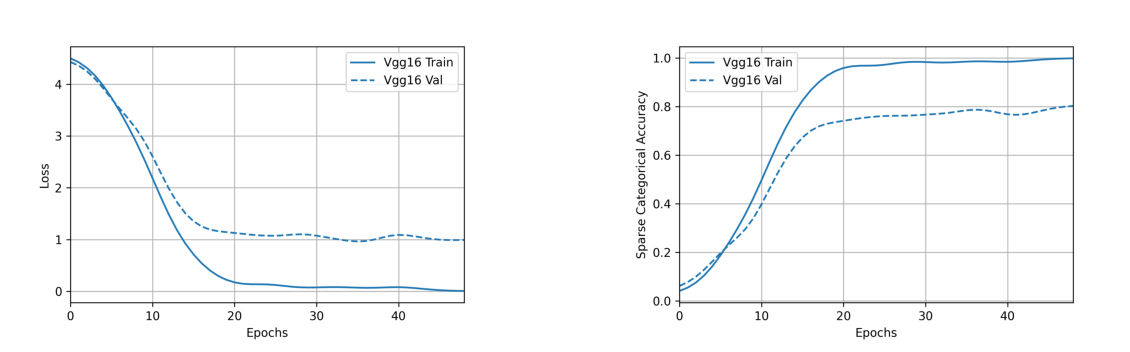

In [7]:
backbone = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(img_sz, img_sz, 3))
backbone.trainable = True
train_with_backbone('VGG16', backbone, 100)
show_figure('VGG16')

94765736/94765736 [==============================] - 3s 0us/step
Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 102)               208998    
                                                                 
 softmax_4 (Softmax)         (None, 102)               0         
                                                                 
Total params: 23,796,710
Trainable params: 23,743,590
Non-t

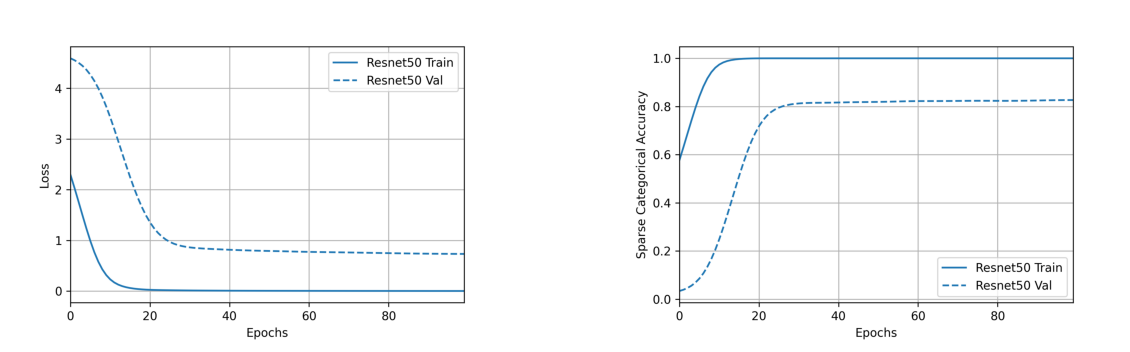

In [8]:
backbone = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(img_sz, img_sz, 3))
backbone.trainable = True
train_with_backbone('ResNet50', backbone, 100)
show_figure('ResNet50')

74836368/74836368 [==============================] - 3s 0us/step
Model: "DenseNet201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 102)               195942    
                                                                 
 softmax (Softmax)           (None, 102)               0         
                                                                 
Total params: 18,517,926
Trainable params: 18,288,870
No

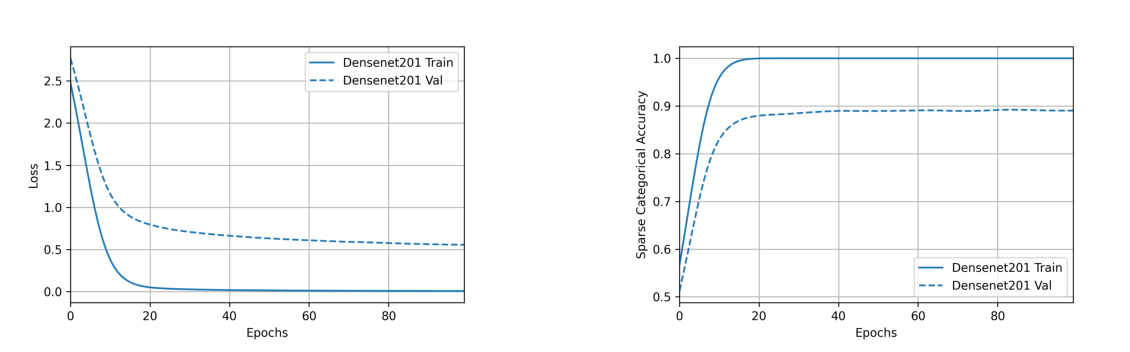

In [9]:
backbone = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet', input_shape=(img_sz, img_sz, 3))
backbone.trainable = True
train_with_backbone('DenseNet201', backbone, 100)
show_figure('DenseNet201')

# Few shot learning

### k-way-n-shot data preparation

In [10]:
# randomly select n samples from k classes
def k_way_n_shot(k, n, df):
  assert k <= num_classes
  # label from [0, k)
  # n shots
  # df need to be shuffled
  cnt = np.full(k, -1)
  sample_id = np.full((k, n), -1)
  all_id = []
  while True:
    for i in range(df.shape[0]):
      lbl = df['label'][i]
      if lbl >= k:
        continue
      if cnt[lbl] >= n - 1:
        continue
      cnt[lbl] += 1
      sample_id[lbl, cnt[lbl]] = i
      all_id.append(i)
    ok = True
    for i in range(k):
      if cnt[i] != n - 1:
        ok = False
        break
    if ok == True:
      return sample_id, all_id

### Model builder definition

In [11]:
# call build_graph to build a model
class FewShotLearningBuilder:
  def __init__(self, support_set_id, k, n):
    # extract the feature of support set
    self.k = k
    self.n = n
    self.feature_extractor = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(img_sz, img_sz, 3))
    support_set = [[None for j in range(n)] for i in range(k)]
    for i in range(k):
      for j in range(n):
        support_set[i][j] = tf.reshape(self.feature_extractor(np.expand_dims(train_df['image'][support_set_id[i][j]], 0)), (-1, ))
    support_set = tf.convert_to_tensor(support_set)
    # get the mean of features of each class
    support_set = tf.math.reduce_mean(support_set, axis = -2)
    # normalize each feature vector
    support_set = self.normalize(support_set)

    self.support_set = support_set
  
  def normalize(self, inputs):
    norm = tf.norm(inputs, ord=2, axis=-1, keepdims=True)
    return inputs / norm
  
  def build_graph(self):
    input = tf.keras.Input(shape=(img_sz, img_sz, 3))
    feature = self.feature_extractor(input)
    feature = tf.keras.layers.Flatten()(feature)
    feature = tf.keras.layers.Dropout(0.25)(feature)
    # feature = tf.keras.layers.BatchNormalization()(feature)
    feature = tf.keras.layers.ReLU()(feature)
    feature = self.normalize(feature)
    dense = tf.keras.layers.Dense(self.k)
    feature = dense(feature)
    output = tf.keras.layers.Softmax()(feature)

    dense.set_weights([tf.transpose(self.support_set), np.zeros((self.k, ))])
    return tf.keras.models.Model(inputs=input, outputs=output)

### Experiment

In [12]:
def train_k_way_n_shot(k, n, epochs, optimizer, topn):
  # data prepare
  support_set_id, all_id = k_way_n_shot(k, n, train_df)
  train_img_valid = np.stack(train_df['image'][all_id].to_numpy())
  # sparse_categorical_crossentropy doesn't provide label_smoothing
  # so we convert trainning data to one-hot vector
  train_label_valid = tf.keras.utils.to_categorical(np.stack(train_df['label'][all_id].to_numpy()), k)
  
  # filter val/test img with labels [0, k)
  val_mask = val_df['label'] < k
  val_img_valid = np.stack(val_df['image'][val_mask].to_numpy())
  val_label_valid = tf.keras.utils.to_categorical(np.stack(val_df['label'][val_mask].to_numpy()), k)

  test_mask = test_df['label'] < k
  test_img_valid = np.stack(test_df['image'][test_mask].to_numpy())
  test_label_valid = np.stack(test_df['label'][test_mask].to_numpy())

  print(f"train data: {len(all_id)}/{train_df.shape[0]}")
  print(f"val data: {val_label_valid.shape[0]}/{val_df.shape[0]}")
  print(f"test data: {test_label_valid.shape[0]}/{test_df.shape[0]}")
  if TRAIN:
    model = FewShotLearningBuilder(support_set_id, k, n).build_graph()
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=f'./ckpts/{k}-way-{n}-shot-best.ckpt',
      save_weights_only=False,
      save_freq='epoch',
      save_best_only=True,
      monitor='val_loss'
    )
    # train
    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        optimizer = optimizer,
        metrics = ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(topn, name=f"top-{topn}-accuracy")]
    )
    train_his = model.fit(
      x=train_img_valid,
      y=train_label_valid,
      validation_data=(val_img_valid, val_label_valid),
      epochs=epochs,
      batch_size=batch_sz,
      workers=multiprocessing.cpu_count(),
      use_multiprocessing=True,
      callbacks=[model_checkpoint_callback],
      verbose='auto'
    )
    model.compile(
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics = ['sparse_categorical_accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(topn, name=f"top-{topn}-accuracy")]
    )
    his = {}
    name = f'{k}-way-{n}-shot'
    his[name] = train_his
    plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
    plotter.plot(his)
    plt.savefig(f'./figures/{name}_loss.png', dpi=300)
    plt.clf()
    plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
    plotter.plot(his)
    plt.savefig(f'./figures/{name}_acc.png', dpi=300)
    plt.clf()
  model_before = tf.keras.models.load_model(f'./ckpts/{k}-way-{n}-shot-before-train.ckpt')
  model_best = tf.keras.models.load_model(f'./ckpts/{k}-way-{n}-shot-best.ckpt')
  model_best.compile(
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics = ['sparse_categorical_accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(topn, name=f"top-{topn}-accuracy")]
    )
  performance_before = model_before.evaluate(test_img_valid, test_label_valid)
  performance_best = model_best.evaluate(test_img_valid, test_label_valid)

  print(f"Use only support-based initialization: loss {performance_before[0]}, accuracy {performance_before[1]}, top{topn} acc {performance_before[2]}")
  print(f"Use support-based and fine-tuning best result: loss {performance_best[0]}, accuracy {performance_best[1]}, top{topn} acc {performance_best[2]}")



train data: 5/1020
val data: 50/1020
test data: 161/6149
6/6 [==============================] - 1s 125ms/step - loss: 1.5007 - sparse_categorical_accuracy: 0.7391 - top-2-accuracy: 0.8447
Use only support-based initialization: loss 1.5515162944793701, accuracy 0.6335403919219971, top2 acc 0.8447204828262329
Use support-based and fine-tuning best result: loss 1.5007460117340088, accuracy 0.739130437374115, top2 acc 0.8447204828262329


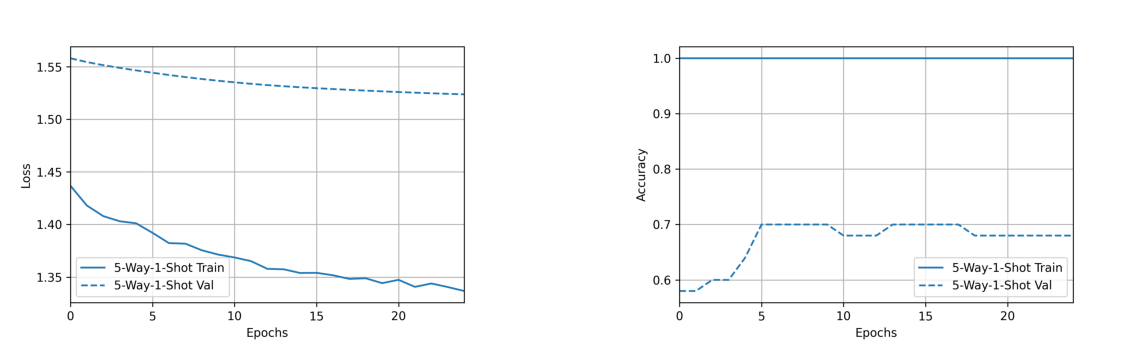

In [13]:
train_df = train_df.sample(frac=1).reset_index().drop(columns='index') # shuffle the dataset
train_k_way_n_shot(k=5, n=1, epochs=25, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), topn=2)
show_figure('5-way-1-shot')

train data: 25/1020
val data: 50/1020
test data: 161/6149
6/6 [==============================] - 1s 126ms/step - loss: 1.4553 - sparse_categorical_accuracy: 0.8634 - top-2-accuracy: 0.9006
Use only support-based initialization: loss 1.5616273880004883, accuracy 0.7950310707092285, top2 acc 0.8447204828262329
Use support-based and fine-tuning best result: loss 1.4552531242370605, accuracy 0.8633540272712708, top2 acc 0.9006211161613464


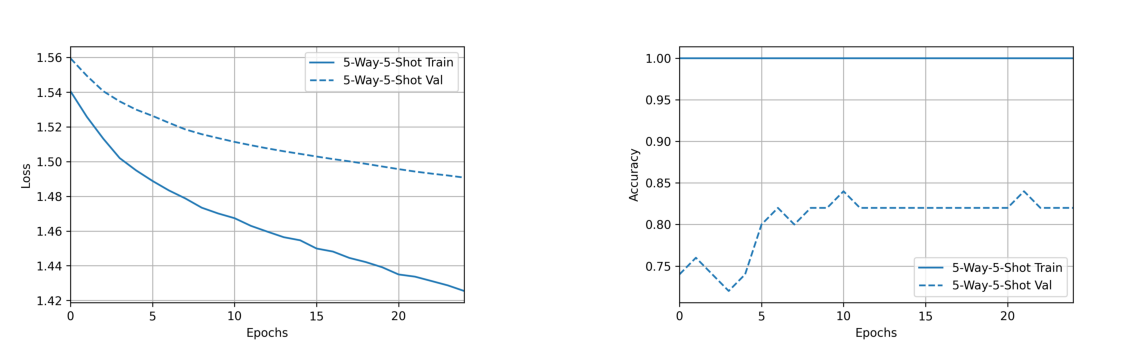

In [14]:
train_df = train_df.sample(frac=1).reset_index().drop(columns='index') # shuffle the dataset
train_k_way_n_shot(k=5, n=5, epochs=25, optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), topn=2)
show_figure('5-way-5-shot')

train data: 102/1020
val data: 1020/1020
test data: 6149/6149
193/193 [==============================] - 32s 162ms/step - loss: 4.5512 - sparse_categorical_accuracy: 0.2355 - top-5-accuracy: 0.4245
Use only support-based initialization: loss 4.581878185272217, accuracy 0.1684826761484146, top5 acc 0.3315986394882202
Use support-based and fine-tuning best result: loss 4.551183223724365, accuracy 0.23548544943332672, top5 acc 0.4244592487812042


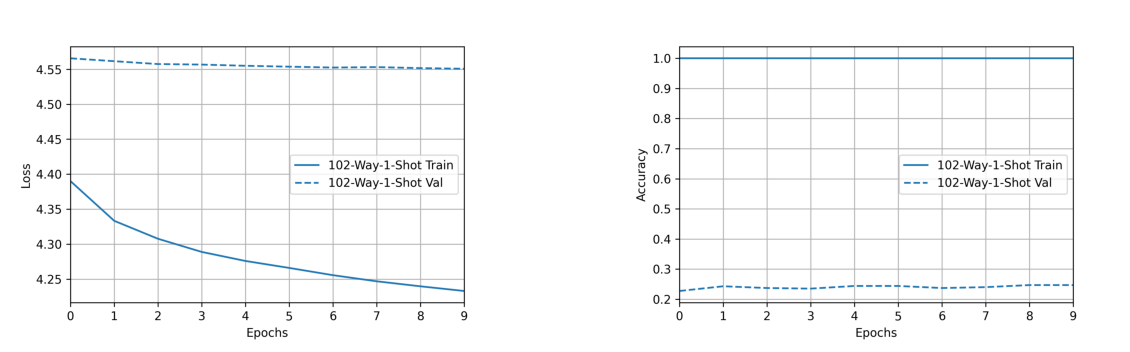

In [15]:
train_df = train_df.sample(frac=1).reset_index().drop(columns='index') # shuffle the dataset
train_k_way_n_shot(k=num_classes, n=1, epochs=10, optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), topn=5)
show_figure(f'102-way-1-shot')

train data: 510/1020
val data: 1020/1020
test data: 6149/6149
193/193 [==============================] - 31s 161ms/step - loss: 4.4325 - sparse_categorical_accuracy: 0.4697 - top-5-accuracy: 0.7221
Use only support-based initialization: loss 4.576138973236084, accuracy 0.44332411885261536, top5 acc 0.6801105737686157
Use support-based and fine-tuning best result: loss 4.432537078857422, accuracy 0.4696698784828186, top5 acc 0.7220686078071594


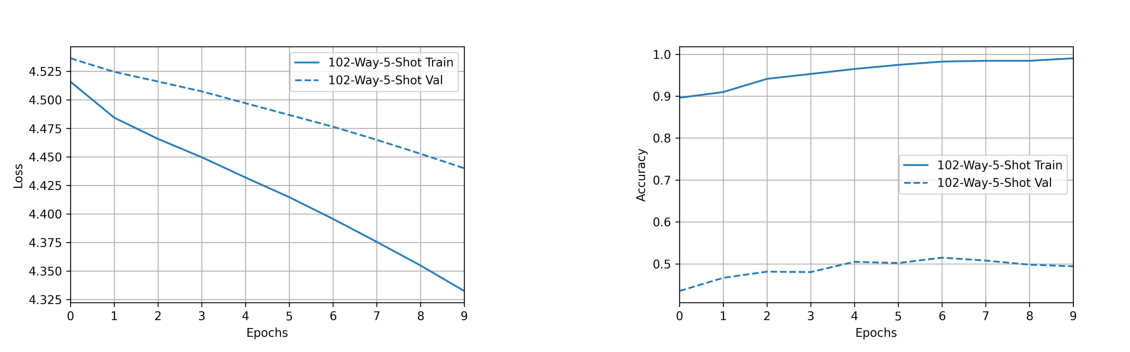

In [16]:
train_df = train_df.sample(frac=1).reset_index().drop(columns='index') # shuffle the dataset
train_k_way_n_shot(k=num_classes, n=5, epochs=10, optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), topn=5)
show_figure(f'102-way-5-shot')

# Visual prompt tuning on vision transformer

### Layer definitions for vision transformer

In [17]:
class ClassToken(tf.keras.layers.Layer):
    """Append a class token to an input layer."""

    def build(self, input_shape):
        cls_init = tf.zeros_initializer()
        self.hidden_size = input_shape[-1]
        self.cls = tf.Variable(
            name="cls",
            initial_value=cls_init(shape=(1, 1, self.hidden_size), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        cls_broadcasted = tf.cast(
            tf.broadcast_to(self.cls, [batch_size, 1, self.hidden_size]),
            dtype=inputs.dtype,
        )
        return tf.concat([cls_broadcasted, inputs], 1)

    def get_config(self):
        config = super().get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


class AddPositionEmbs(tf.keras.layers.Layer):
    """Adds (optionally learned) positional embeddings to the inputs."""

    def build(self, input_shape):
        assert (
            len(input_shape) == 3
        ), f"Number of dimensions should be 3, got {len(input_shape)}"
        self.pe = tf.Variable(
            name="pos_embedding",
            initial_value=tf.random_normal_initializer(stddev=0.06)(
                shape=(1, input_shape[1], input_shape[2])
            ),
            dtype="float32",
            trainable=True,
        )

    def call(self, inputs):
        return inputs + tf.cast(self.pe, dtype=inputs.dtype)

    def get_config(self):
        config = super().get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, *args, num_heads, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_heads = num_heads

    def build(self, input_shape):
        hidden_size = input_shape[-1]
        num_heads = self.num_heads
        if hidden_size % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {hidden_size} should be divisible by number of heads = {num_heads}"
            )
        self.hidden_size = hidden_size
        self.projection_dim = hidden_size // num_heads
        self.query_dense = tf.keras.layers.Dense(hidden_size, name="query")
        self.key_dense = tf.keras.layers.Dense(hidden_size, name="key")
        self.value_dense = tf.keras.layers.Dense(hidden_size, name="value")
        self.combine_heads = tf.keras.layers.Dense(hidden_size, name="out")

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], score.dtype)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.hidden_size))
        output = self.combine_heads(concat_attention)
        return output, weights

    def get_config(self):
        config = super().get_config()
        config.update({"num_heads": self.num_heads})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


class TransformerBlock(tf.keras.layers.Layer):
    """Implements a Transformer block."""

    def __init__(self, *args, num_heads, mlp_dim, dropout, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.att = MultiHeadSelfAttention(
            num_heads=self.num_heads,
            name="MultiHeadDotProductAttention_1",
        )
        self.mlpblock = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(
                    self.mlp_dim,
                    activation="linear",
                    name=f"{self.name}/Dense_0",
                ),
                tf.keras.layers.Lambda(
                    lambda x: tf.keras.activations.gelu(x, approximate=False)
                )
                if hasattr(tf.keras.activations, "gelu")
                else tf.keras.layers.Lambda(
                    lambda x: tfa.activations.gelu(x, approximate=False)
                ),
                tf.keras.layers.Dropout(self.dropout),
                tf.keras.layers.Dense(input_shape[-1], name=f"{self.name}/Dense_1"),
                tf.keras.layers.Dropout(self.dropout),
            ],
            name="MlpBlock_3",
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(
            epsilon=1e-6, name="LayerNorm_0"
        )
        self.layernorm2 = tf.keras.layers.LayerNormalization(
            epsilon=1e-6, name="LayerNorm_2"
        )
        self.dropout_layer = tf.keras.layers.Dropout(self.dropout)

    def call(self, inputs, training):
        x = self.layernorm1(inputs)
        x, weights = self.att(x)
        x = self.dropout_layer(x, training=training)
        x = x + inputs
        y = self.layernorm2(x)
        y = self.mlpblock(y)
        return x + y, weights

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "num_heads": self.num_heads,
                "mlp_dim": self.mlp_dim,
                "dropout": self.dropout,
            }
        )
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

### utils for loading weights

In [18]:
BASE_URL = "https://github.com/faustomorales/vit-keras/releases/download/dl"

def apply_embedding_weights(target_layer, source_weights, num_x_patches, num_y_patches):
    """Apply embedding weights to a target layer.
    Args:
        target_layer: The target layer to which weights will
            be applied.
        source_weights: The source weights, which will be
            resized as necessary.
        num_x_patches: Number of patches in width of image.
        num_y_patches: Number of patches in height of image.
    """
    expected_shape = target_layer.weights[0].shape
    if expected_shape != source_weights.shape:
        token, grid = source_weights[0, :1], source_weights[0, 1:]
        sin = int(np.sqrt(grid.shape[0]))
        sout_x = num_x_patches
        sout_y = num_y_patches
        warnings.warn(
            "Resizing position embeddings from " f"{sin}, {sin} to {sout_x}, {sout_y}",
            UserWarning,
        )
        zoom = (sout_y / sin, sout_x / sin, 1)
        grid = sp.ndimage.zoom(grid.reshape(sin, sin, -1), zoom, order=1).reshape(
            sout_x * sout_y, -1
        )
        source_weights = np.concatenate([token, grid], axis=0)[np.newaxis]
    target_layer.set_weights([source_weights])

def load_weights_numpy(
    model, params_path, pretrained_top, num_x_patches, num_y_patches
):
    """Load weights saved using Flax as a numpy array.
    Args:
        model: A Keras model to load the weights into.
        params_path: Filepath to a numpy archive.
        pretrained_top: Whether to load the top layer weights.
        num_x_patches: Number of patches in width of image.
        num_y_patches: Number of patches in height of image.
    """
    params_dict = np.load(
        params_path, allow_pickle=False
    )  # pylint: disable=unexpected-keyword-arg
    source_keys = list(params_dict.keys())
    pre_logits = any(l.name == "pre_logits" for l in model.layers)
    source_keys_used = []
    n_transformers = len(
        set(
            "/".join(k.split("/")[:2])
            for k in source_keys
            if k.startswith("Transformer/encoderblock_")
        )
    )
    n_transformers_out = sum(
        l.name.startswith("Transformer/encoderblock_") for l in model.layers
    )
    assert n_transformers == n_transformers_out, (
        f"Wrong number of transformers ("
        f"{n_transformers_out} in model vs. {n_transformers} in weights)."
    )

    matches = []
    for tidx in range(n_transformers):
        encoder = model.get_layer(f"Transformer/encoderblock_{tidx}")
        source_prefix = f"Transformer/encoderblock_{tidx}"
        matches.extend(
            [
                {
                    "layer": layer,
                    "keys": [
                        f"{source_prefix}/{norm}/{name}" for name in ["scale", "bias"]
                    ],
                }
                for norm, layer in [
                    ("LayerNorm_0", encoder.layernorm1),
                    ("LayerNorm_2", encoder.layernorm2),
                ]
            ]
            + [
                {
                    "layer": encoder.mlpblock.get_layer(
                        f"{source_prefix}/Dense_{mlpdense}"
                    ),
                    "keys": [
                        f"{source_prefix}/MlpBlock_3/Dense_{mlpdense}/{name}"
                        for name in ["kernel", "bias"]
                    ],
                }
                for mlpdense in [0, 1]
            ]
            + [
                {
                    "layer": layer,
                    "keys": [
                        f"{source_prefix}/MultiHeadDotProductAttention_1/{attvar}/{name}"
                        for name in ["kernel", "bias"]
                    ],
                    "reshape": True,
                }
                for attvar, layer in [
                    ("query", encoder.att.query_dense),
                    ("key", encoder.att.key_dense),
                    ("value", encoder.att.value_dense),
                    ("out", encoder.att.combine_heads),
                ]
            ]
        )
    for layer_name in ["embedding", "head", "pre_logits"]:
        if layer_name == "head" and not pretrained_top:
            source_keys_used.extend(["head/kernel", "head/bias"])
            continue
        if layer_name == "pre_logits" and not pre_logits:
            continue
        matches.append(
            {
                "layer": model.get_layer(layer_name),
                "keys": [f"{layer_name}/{name}" for name in ["kernel", "bias"]],
            }
        )
    matches.append({"layer": model.get_layer("class_token"), "keys": ["cls"]})
    matches.append(
        {
            "layer": model.get_layer("Transformer/encoder_norm"),
            "keys": [f"Transformer/encoder_norm/{name}" for name in ["scale", "bias"]],
        }
    )
    apply_embedding_weights(
        target_layer=model.get_layer("Transformer/posembed_input"),
        source_weights=params_dict["Transformer/posembed_input/pos_embedding"],
        num_x_patches=num_x_patches,
        num_y_patches=num_y_patches,
    )
    source_keys_used.append("Transformer/posembed_input/pos_embedding")
    for match in matches:
        source_keys_used.extend(match["keys"])
        source_weights = [params_dict[k] for k in match["keys"]]
        if match.get("reshape", False):
            source_weights = [
                source.reshape(expected.shape)
                for source, expected in zip(
                    source_weights, match["layer"].get_weights()
                )
            ]
        match["layer"].set_weights(source_weights)
    unused = set(source_keys).difference(source_keys_used)
    if unused:
        warnings.warn(f"Did not use the following weights: {unused}", UserWarning)
    target_keys_set = len(source_keys_used)
    target_keys_all = len(model.weights)
    if target_keys_set < target_keys_all:
        warnings.warn(
            f"Only set {target_keys_set} of {target_keys_all} weights.", UserWarning
        )

def load_pretrained(
    size: str,
    pretrained_top: bool,
    model: tf.keras.models.Model,
    weights="imagenet21k",
    image_size=224,
    patch_size=16,
):
    """Load model weights for a known configuration."""
    image_size_tuple = (image_size, image_size)
    fname = f"ViT-{size}_{weights}.npz"
    origin = f"{BASE_URL}/{fname}"
    local_filepath = tf.keras.utils.get_file(fname, origin, cache_subdir="weights")
    load_weights_numpy(
        model=model,
        params_path=local_filepath,
        pretrained_top=pretrained_top,
        num_x_patches=image_size_tuple[1] // patch_size,
        num_y_patches=image_size_tuple[0] // patch_size,
    )

### Layer definitions for visual tuning

In [19]:
class PromptLayer(tf.keras.layers.Layer):
    """Append a class token to an input layer."""
    p = 5 # 2nd dimention of prompts

class AppendPrompt(PromptLayer):
    def build(self, input_shape):
        prompt_init = tf.zeros_initializer()
        self.hidden_size = input_shape[-1]
        self.prompt = tf.Variable(
            name="append_prompt",
            initial_value=prompt_init(shape=(1, self.p, self.hidden_size), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        cls = inputs[:, 0:1]
        features = inputs[:, 1:]
        prompt_broadcasted = tf.cast(
            tf.broadcast_to(self.prompt, [batch_size, self.p, self.hidden_size]),
            dtype=inputs.dtype,
        )
        return tf.concat([cls, prompt_broadcasted, features], 1)

    def get_config(self):
        config = super().get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

class DelPrompt(PromptLayer):
  def call(self, inputs):
    cls = inputs[:, 0:1, :]
    features = inputs[:, self.p + 1:]
    return tf.concat([cls, features], 1)
  

### Model definition

In [20]:
def build_model(
    image_size=224,
    patch_size=16,
    num_layers=12,
    hidden_size=768,
    num_heads=12,
    name='vit-b16',
    mlp_dim=3072,
    classes=num_classes,
    dropout=0.1,
    deep = False
):
    image_size_tuple = (image_size, image_size)
    assert (image_size_tuple[0] % patch_size == 0) and (
        image_size_tuple[1] % patch_size == 0
    ), "image_size must be a multiple of patch_size"
    x = tf.keras.layers.Input(shape=(image_size_tuple[0], image_size_tuple[1], 3))
    y = tf.keras.layers.Conv2D(
        filters=hidden_size,
        kernel_size=patch_size,
        strides=patch_size,
        padding="valid",
        name="embedding",
    )(x)
    y = tf.keras.layers.Reshape((y.shape[1] * y.shape[2], hidden_size))(y)
    y = ClassToken(name="class_token")(y)
    y = AddPositionEmbs(name="Transformer/posembed_input")(y)

    if deep == True:
      for n in range(num_layers):
          y = AppendPrompt()(y)
          y, _ = TransformerBlock(
              num_heads=num_heads,
              mlp_dim=mlp_dim,
              dropout=dropout,
              name=f"Transformer/encoderblock_{n}",
          )(y)
          y = DelPrompt()(y)
    else:
      y = AppendPrompt()(y)
      for n in range(num_layers):
          y, _ = TransformerBlock(
              num_heads=num_heads,
              mlp_dim=mlp_dim,
              dropout=dropout,
              name=f"Transformer/encoderblock_{n}",
          )(y)
    y = tf.keras.layers.LayerNormalization(
        epsilon=1e-6, name="Transformer/encoder_norm"
    )(y)
    y = tf.keras.layers.Lambda(lambda v: v[:, 0], name="ExtractToken")(y)
    return tf.keras.models.Model(inputs=x, outputs=y, name=name)

## Experiment

In [21]:
def freeze(model):
  for layer in model.layers:
    if "prompt" in layer.name:
      layer.trainable=True
    else:
      layer.trainable=False

In [22]:
def train_vit(name, vit, epochs=100):
  if TRAIN:
    model = tf.keras.Sequential([
      vit,
      tf.keras.layers.Dense(num_classes, activation='relu'),
      tf.keras.layers.Softmax()
    ])
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=f'./ckpts/{name}.ckpt',
      save_weights_only=False,
      save_freq='epoch',
      save_best_only=True,
      monitor='val_loss'
    )
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    model.compile(
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.SGD(0.01),
        metrics = ['sparse_categorical_accuracy']
    )
    train_his = model.fit(
      x=np.stack(train_df['image'].to_numpy()),
      y=np.stack(train_df['label'].to_numpy()),
      validation_data=(np.stack(val_df['image'].to_numpy()), np.stack(val_df['label'].to_numpy())),
      epochs=epochs,
      batch_size=batch_sz,
      workers=multiprocessing.cpu_count(),
      use_multiprocessing=True,
      callbacks=[model_checkpoint_callback, earlystop_callback],
      verbose='auto'
    )
    his = {}
    his[name] = train_his
    plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
    plotter.plot(his)
    plt.savefig(f'./figures/{name}_loss.png', dpi=300)
    plt.clf()
    plotter = tfdocs.plots.HistoryPlotter(metric = 'sparse_categorical_accuracy', smoothing_std=10)
    plotter.plot(his)
    plt.savefig(f'./figures/{name}_acc.png', dpi=300)
    plt.clf()
  model = tf.keras.models.load_model(f"./ckpts/{name}.ckpt")
  model.summary()
  model.evaluate(np.stack(test_df['image'].to_numpy()), np.stack(test_df['label'].to_numpy()))

build model for VPT (shallow) and load pretrained weights

In [23]:
vit_b16_shallow = build_model(deep=False)
load_pretrained(size="B_16", model=vit_b16_shallow, pretrained_top=False) # 331MB
vit_b16_shallow.summary()

412815506/412815506 [==============================] - 55s 0us/step
Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 append_prompt (AppendPrompt  (None, 202, 768)         38

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: UserWarning: Did not use the following weights: {'pre_logits/kernel', 'pre_logits/bias'}


freeze the model and train

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85802496  
                                                                 
 dense_1 (Dense)             (None, 102)               78438     
                                                                 
 softmax_1 (Softmax)         (None, 102)               0         
                                                                 
Total params: 85,880,934
Trainable params: 82,278
Non-trainable params: 85,798,656
_________________________________________________________________
193/193 [==============================] - 87s 443ms/step - loss: 2.4151 - sparse_categorical_accuracy: 0.8213


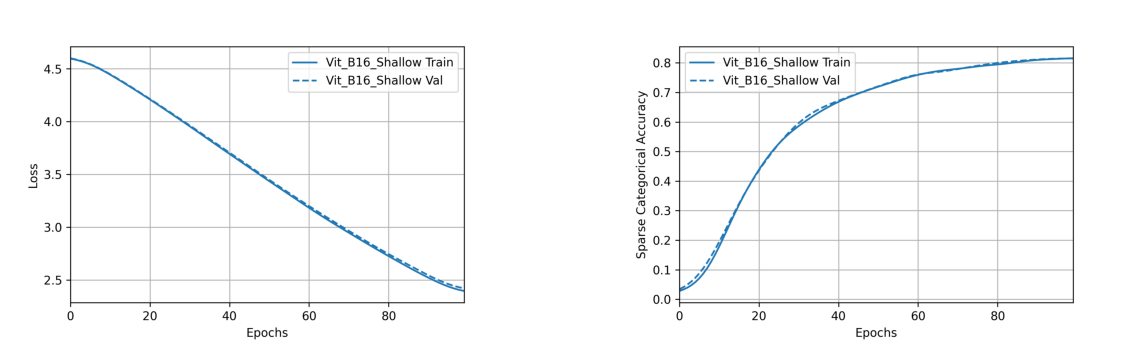

In [24]:
freeze(vit_b16_shallow)
train_vit('vit_b16_shallow', vit_b16_shallow, 100)
show_figure('vit_b16_shallow')

build model for VPT (deep) and load pretrained weights

In [25]:
vit_b16_deep = build_model(deep=True)
load_pretrained(size="B_16", model=vit_b16_deep, pretrained_top=False) # 331MB
vit_b16_deep.summary()

Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape_1 (Reshape)         (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 append_prompt_1 (AppendProm  (None, 202, 768)         3840      
 pt)                                                       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: UserWarning: Did not use the following weights: {'pre_logits/kernel', 'pre_logits/bias'}
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:152: UserWarning: Only set 200 of 210 weights.


                                                                 
 ExtractToken (Lambda)       (None, 768)               0         
                                                                 
Total params: 85,844,736
Trainable params: 85,844,736
Non-trainable params: 0
_________________________________________________________________


freeze the model and train

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 dense (Dense)               (None, 102)               78438     
                                                                 
 softmax (Softmax)           (None, 102)               0         
                                                                 
Total params: 85,923,174
Trainable params: 124,518
Non-trainable params: 85,798,656
_________________________________________________________________
193/193 [==============================] - 88s 450ms/step - loss: 2.1760 - sparse_categorical_accuracy: 0.7474


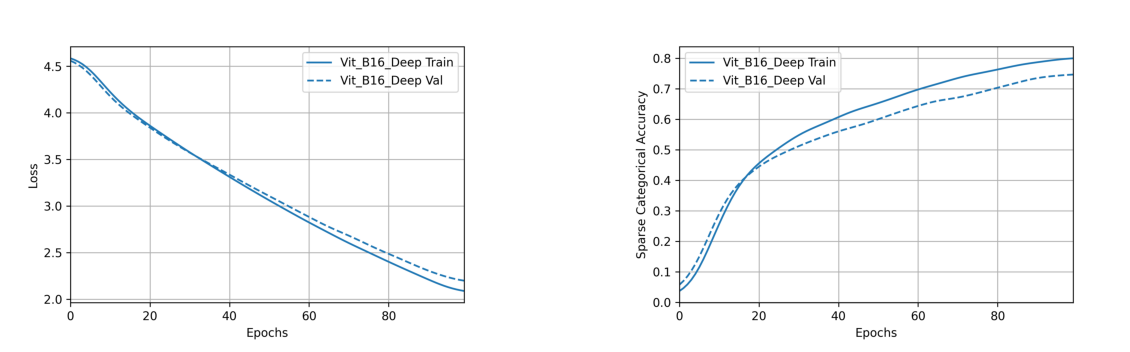

In [26]:
freeze(vit_b16_deep)
train_vit('vit_b16_deep', vit_b16_deep, 100)
show_figure('vit_b16_deep')

# Discovery on more loss funtion

In [27]:
def train_vgg16(loss_name, loss_fn, epochs):
  if TRAIN:
    model = tf.keras.Sequential([
      tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(img_sz, img_sz, 3)),
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
      tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name=loss_name)
    model.compile(
      loss = loss_fn,
      optimizer = tf.keras.optimizers.SGD(0.1)
    )
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=f"./ckpts/{loss_name}.ckpt",
      save_weights_only=False,
      save_freq='epoch',
      save_best_only=True,
      monitor='val_loss'
    )
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    train_his = model.fit(
      x=np.stack(train_df['image'].to_numpy()),
      y=np.stack(train_df['label'].to_numpy()),
      validation_data = (np.stack(val_df['image'].to_numpy()), np.stack(val_df['label'].to_numpy())),
      epochs=epochs,
      batch_size=batch_sz,
      workers=multiprocessing.cpu_count(),
      use_multiprocessing=True,
      callbacks = [model_checkpoint_callback, earlystop_callback],
      verbose='auto'
    )
    his = {}
    his[loss_name] = train_his
    plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
    plotter.plot(his)
    plt.savefig(f'./figures/{loss_name}_loss.png', dpi=300)
    plt.clf()


In [28]:
def show_accuracy(loss_name):
  model = tf.keras.models.load_model(f"./ckpts/{loss_name}.ckpt")
  # prepare support set
  # vec_list[k] stores all feature embedding of class k
  vec_list = []
  for i in range(num_classes):
    vec_list.append([])
  train_img = np.stack(train_df['image'].to_numpy())
  train_label = np.stack(train_df['label'].to_numpy())
  vec_pred = model.predict(train_img)
  for i in range(vec_pred.shape[0]):
    vec_list[train_label[i]].append(vec_pred[i])
  # for each class, calculate a average feature embedding
  for i in range(num_classes):
    vec_list[i] = tf.math.reduce_mean(tf.convert_to_tensor(vec_list[i]), axis = -2)
  support_vec = tf.convert_to_tensor(vec_list)
  
  # prepare test set
  test_img = np.stack(test_df['image'].to_numpy())
  test_label = np.stack(test_df['label'].to_numpy())
  vec_pred = model.predict(test_img)

  # calculte l2 distance between vec_pred and each support_vec
  dis_l2 = tf.norm(tf.expand_dims(vec_pred, axis=1) - support_vec, axis=-1) 
  pred = tf.argmin(dis_l2, axis=-1) # prediction is the closest class
  acc = tf.reduce_mean(tf.cast(pred == test_label, dtype='float64'))
  print(f"The model is trained using {loss_name}, test accuracy is {acc}") 

  # Save test embeddings for visualization in projector
  np.savetxt(f"{loss_name}_vecs.tsv", vec_pred, delimiter='\t')

  out_m = io.open(f'{loss_name}_meta.tsv', 'w', encoding='utf-8')
  for dic in tfds.as_numpy(test_ds.batch(batch_sz)):
    labels = dic['label']
    [out_m.write(str(x) + "\n") for x in labels]
  out_m.close()

### Triplet loss

triplet hard/semi hard loss

193/193 [==============================] - 31s 160ms/step
The model is trained using TripletHardLoss, test accuracy is 0.8367214181167669


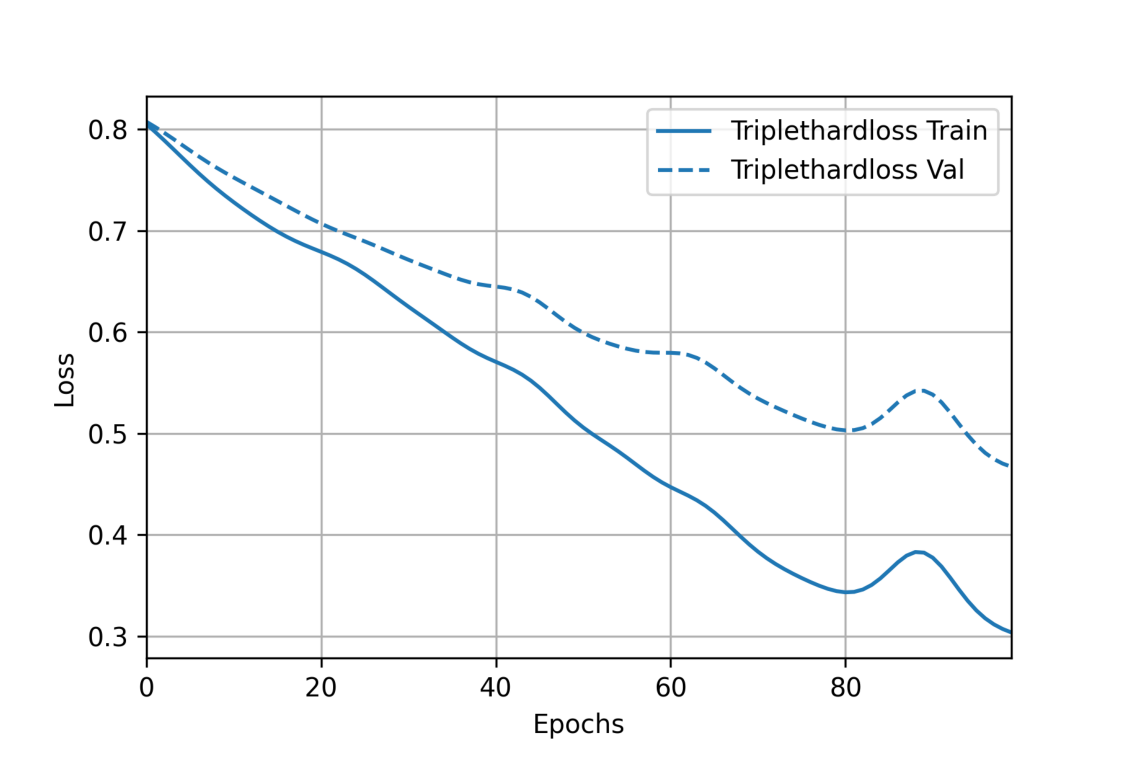

In [29]:
train_vgg16('TripletHardLoss', tfa.losses.TripletHardLoss(distance_metric='L2'), 100)
show_accuracy('TripletHardLoss')
img_loss = mpimg.imread(f'./figures/TripletHardLoss_loss.png')
plt.figure(figsize=(20, 25))
plt.imshow(img_loss)
plt.axis('off')
plt.show()

193/193 [==============================] - 31s 160ms/step
The model is trained using TripletSemiHardLoss, test accuracy is 0.7819157586599447


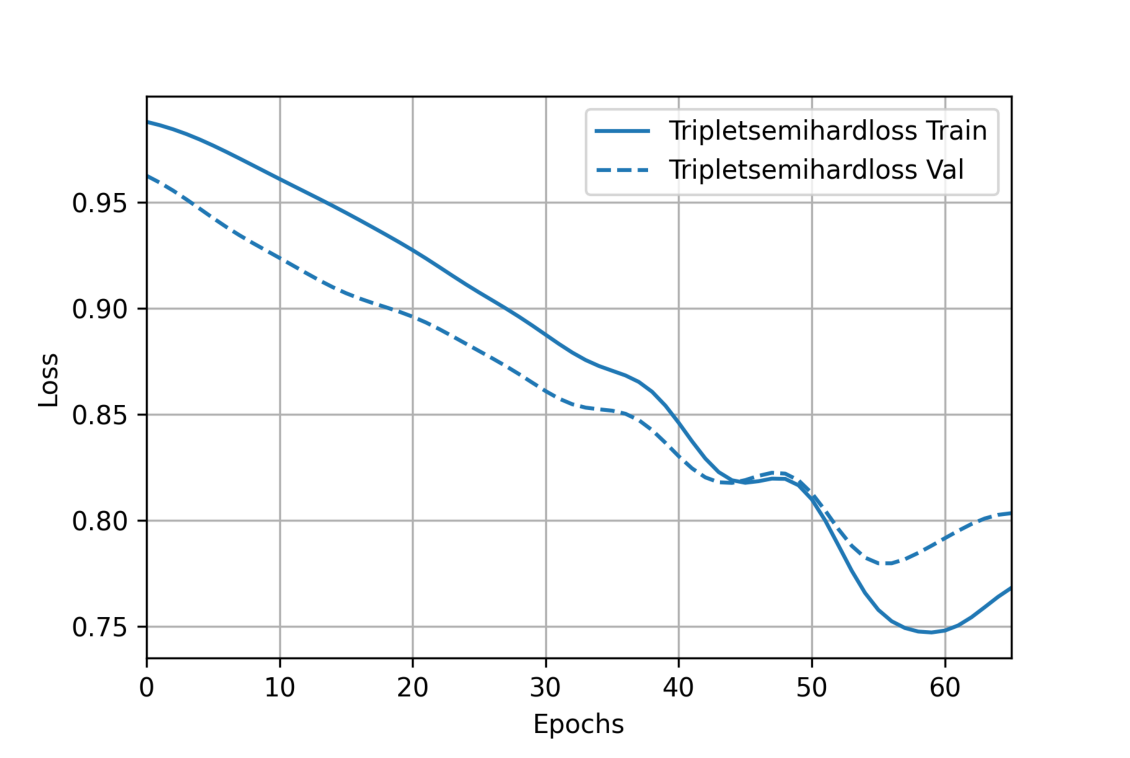

In [30]:
# select batch size >= num_classes
# use larger batch size to find more valid triplet
# if batch size too small, might get nan loss
batch_sz=128

train_vgg16('TripletSemiHardLoss', tfa.losses.TripletSemiHardLoss(distance_metric='L2'), 100)
show_accuracy('TripletSemiHardLoss')
img_loss = mpimg.imread(f'./figures/TripletSemiHardLoss_loss.png')
plt.figure(figsize=(20, 25))
plt.imshow(img_loss)
plt.axis('off')
plt.show()